from your main directory, create a numbers subdirectory and morenumbers subdirectory 
and unzip appropriate files into each directory

create three more directories called: dBFS, trimmed and special

you will need to install pydub, thinkx (thinkdsp) and librosa if you don't already have them

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import shutil
import argparse
from glob import glob
from statistics import mean 
import csv
import copy

# import soundfile as sf
import struct
import wave
from pydub import AudioSegment
from pydub import silence
# import audioop

import thinkdsp
import thinkplot
import librosa as lr

%matplotlib inline
plt.style.use('ggplot')


# import sklearn as sklearn
# from sklearn import preprocessing
# from sklearn import utils
# from sklearn import preprocessing, svm
# from sklearn import decomposition
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import matthews_corrcoef
# from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
# from sklearn import linear_model, metrics, svm, ensemble
# from sklearn.model_selection  import train_test_split, cross_val_score, ShuffleSplit
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.svm import SVC, LinearSVC, NuSVC
# from itertools import combinations 

# from sklearn.metrics import accuracy_score, log_loss
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# import warnings
# import sys

# print(np.__version__)

In [2]:
#support functions
def delete_files_in_directory(dirs):  #delete all files in passed dirs (list)
    [os.remove(f) for each_dir in dirs for f in glob(each_dir+'/*.*')]

def copy_files(source_dir, dest_dir, n_files=100000): #copies files from source to dest - defaults to 100,000 files
    [shutil.copy(file, dest_dir+'/') for i, file in enumerate(glob(source_dir+'/*.*')) if i < n_files]

In [3]:
#returns leading part of array which meats the silence threshold..  for back of file, reversed array is sent...
def detect_leading_silence(sound, silence_threshold=-30.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [4]:
# #additional functions not currently used but I anticipate using... 
# def mean_negative(L): #takes the mean of all negative numbers #probably should add invalid mask
#     # Get all negative numbers into another list
#     neg_only = [x for x in L if x < 0]
#     if neg_only:
#         return sum(neg_only) /  len(neg_only)
#     raise ValueError('No negative numbers in input')    

# def mean_positive(L):#takes the mean of all positive numbers #probably should add invalid mask
#     # Get all positive numbers into another list
#     pos_only = [x for x in L if x > 0]
#     if pos_only:
#         return sum(pos_only) /  len(pos_only)
#     raise ValueError('No postive numbers in input')

# def appendDFToCSV_void(df, csvFilePath, sep=","):  #saves DF to csv
#     if not os.path.isfile(csvFilePath):
#         df.to_csv(csvFilePath, mode='a', index=False, sep=sep)
#     elif len(df.columns) != len(pd.read_csv(csvFilePath, nrows=1, sep=sep).columns):
#         raise Exception("Columns do not match!! Dataframe has " + str(len(df.columns)) + " columns. CSV file has " + str(len(pd.read_csv(csvFilePath, nrows=1, sep=sep).columns)) + " columns.")
#     elif not (df.columns == pd.read_csv(csvFilePath, nrows=1, sep=sep).columns).all():
#         raise Exception("Columns and column order of dataframe and csv file do not match!!")
#     else:
#         df.to_csv(csvFilePath, mode='a', index=False, sep=sep, header=False)

In [5]:
#get audio files, setup export directory and filenames

working_dir = 'working' #files are copied here from input directories below

#input directories
org_dir = 'counting'   #these are the original files I created
numbers1_dir = 'numbers'  #numbers from Matt
numbers2_dir = 'morenumbers'  #more numbers from Matt

dBFS_dir = 'dBFS'  #export of graph in jpg of trimmed files
trim_dir = 'trimmed' #trimmed files
spl_dir = 'special'  #trimmed files with space added for comparison graphs

### set qty of working files for testing...

In [6]:
#clear calculated directories trim, spl and working
dirs_to_clear = [trim_dir, spl_dir, working_dir, dBFS_dir]  #list of directories to delete files
delete_files_in_directory(dirs_to_clear)  #delete files from the list above

# copy_files(org_dir, working_dir, n_files=10000)  #copy files to working directory (these are the files that will be processed)

copy_files(numbers1_dir, working_dir, n_files=15) #copy files to working directory (these are the files that will be processed


In [7]:
#populate lists with file names (not directories) - I should probably put this all in one directory but I havn't gotten there
working_files = [os.path.basename(x) for x in glob(working_dir+'/*.wav')] 
trim_files = [os.path.splitext(x)[0]+'_trim.wav' for x in working_files] 
spl_files = [os.path.splitext(x)[0]+'_spl.wav' for x in working_files] 
dBFS_files = [os.path.splitext(x)[0]+'_dBFS.jpg' for x in working_files] 

In [8]:
#trim noise from files and log misc information 
log_cols=["File_Name","Spoken_Nbr", "dBFS_mean", "dBFS_std", "dBFS_thresh", "org_dur", "trim_dur"] 
log = pd.DataFrame(columns=log_cols)

#process all the files
for c, file in enumerate(working_files):
    m_filename = os.path.join(working_dir,file)  #main working files
    t_filename = os.path.join(trim_dir,trim_files[c])  #trim files
    s_filename = os.path.join(spl_dir,spl_files[c]) #special files (for graphing - trim file plus white space as 0's to align)

    sound = AudioSegment.from_file(m_filename, format="wav")
    seconds_to_skip = .25 * 1000 #trim .25 sec off front of file - virtually noone talkes that fast and there is often initial microphone noise
    sound = sound[seconds_to_skip:len(sound)] #trim sound
    
    #get a list of dBFS
    all_dBFS = []
    for i in range(len(sound)):    
        all_dBFS.append([sound[i:i+1].dBFS])
    
    #get the mean, stdev and determin threah (threah determins how silence is determined)
    dBFS_mean = np.ma.masked_invalid(all_dBFS).mean()
    dBFS_std = np.ma.masked_invalid(all_dBFS).std()
    dBFS_thresh = dBFS_mean + dBFS_std
    
    start_trim = detect_leading_silence(sound, silence_threshold=dBFS_thresh, chunk_size=20)   #get leading silence
    end_trim = detect_leading_silence(sound.reverse(), silence_threshold=dBFS_thresh, chunk_size=20) #get trailing silence

    duration = len(sound)    #length of sound
    trimmed_sound = sound[start_trim:duration-end_trim] #trim the sound
    trimmed_sound.export(t_filename, format="wav") #Exports to a wav file in trimmed directory
    
    #set the beginning and ending silence to match length of original audio clip
    silence_start = AudioSegment.silent(duration=start_trim+ seconds_to_skip) #make initial blank sound
    silence_end = AudioSegment.silent(duration=end_trim) #make ending blank sound
    
    #combine audio files 
    newAudio1 = trimmed_sound + silence_end
    newAudio1 = silence_start + newAudio1  #no sound should be the same length as the original sound
    
    #export file
    newAudio1.export(s_filename, format="wav") #Exports to a wav file in the special directory (for graphing only)

    #update the log with misc info
    log_entry = pd.DataFrame([[file, file[:2], dBFS_mean, dBFS_std, dBFS_thresh, len(sound), len(trimmed_sound)]], columns=log_cols)
    log = log.append(log_entry)
    

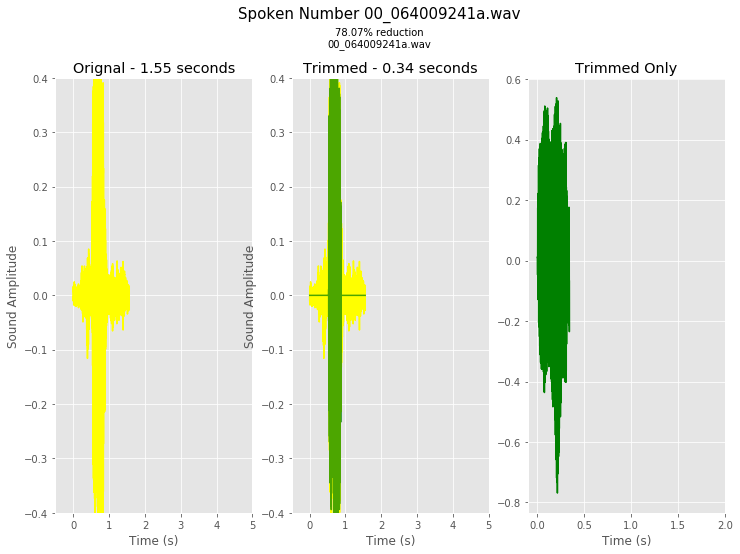

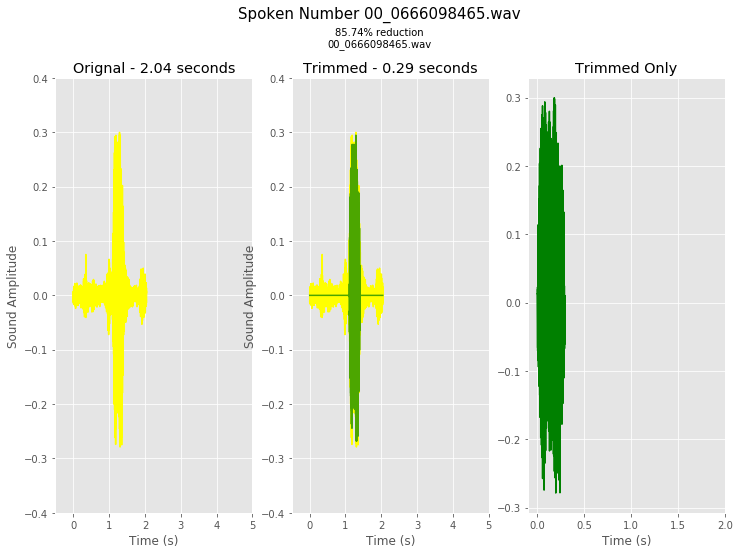

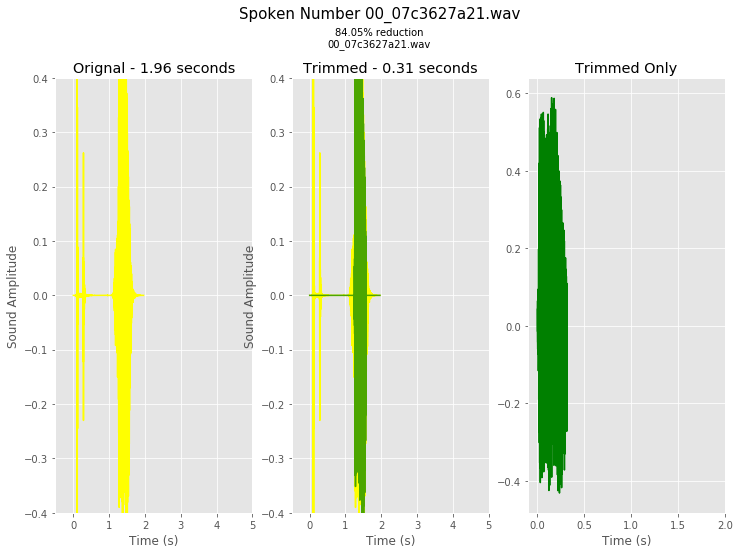

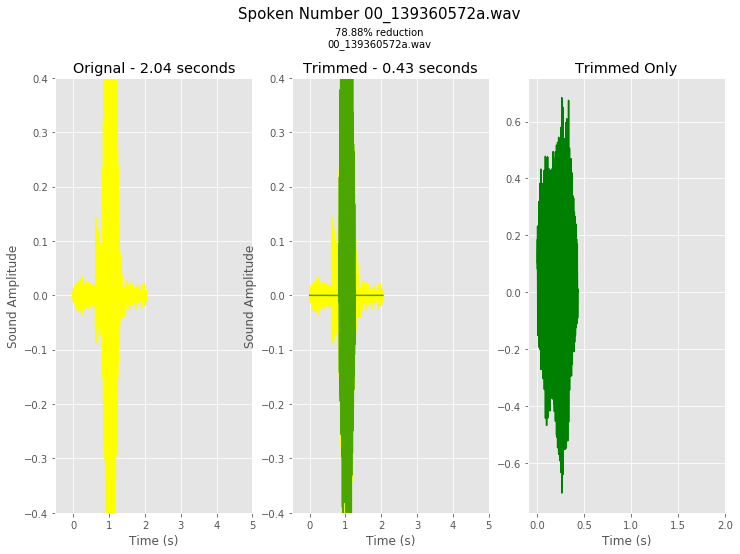

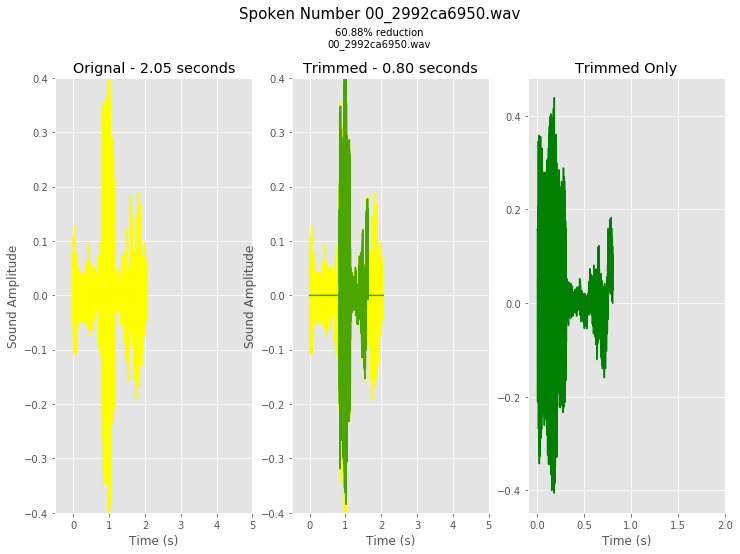

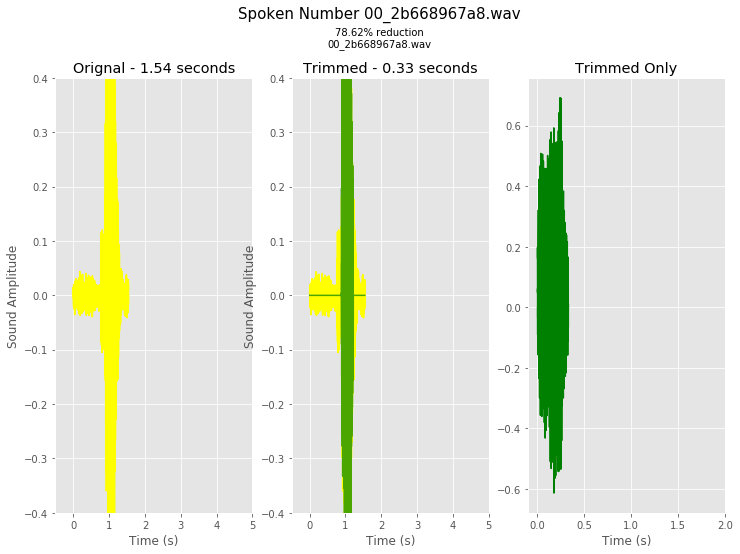

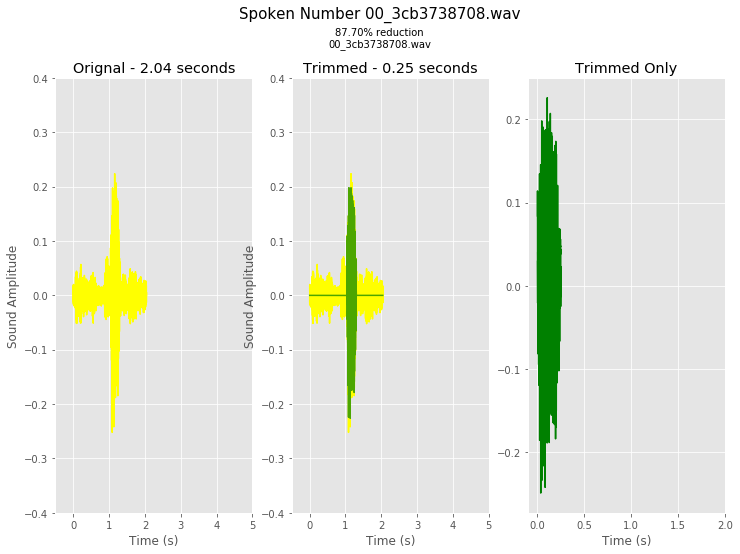

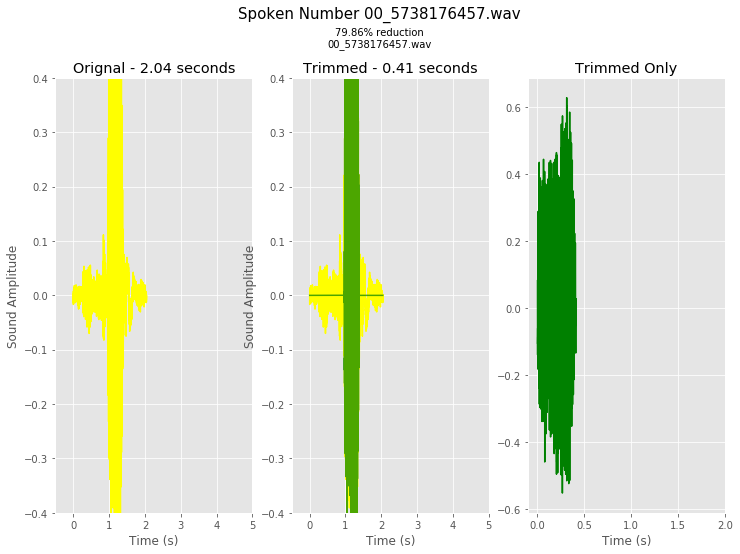

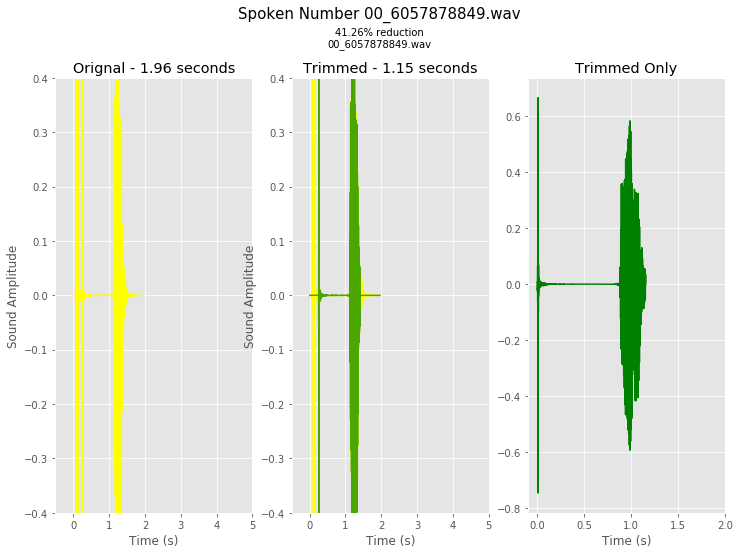

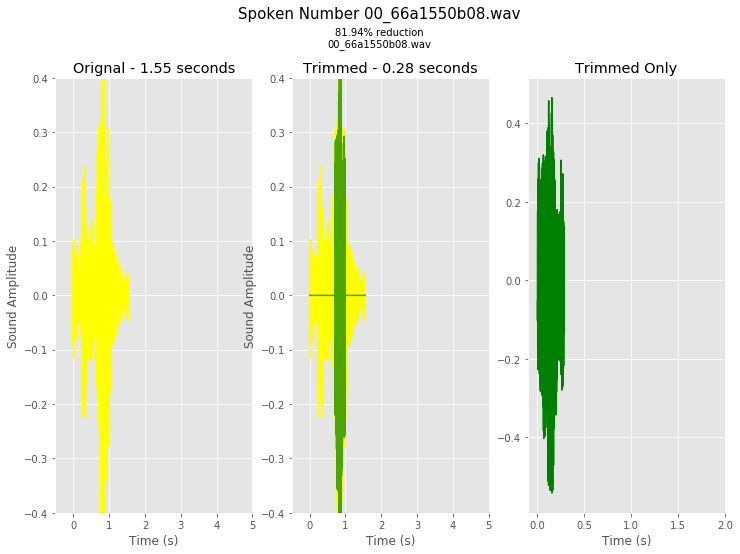

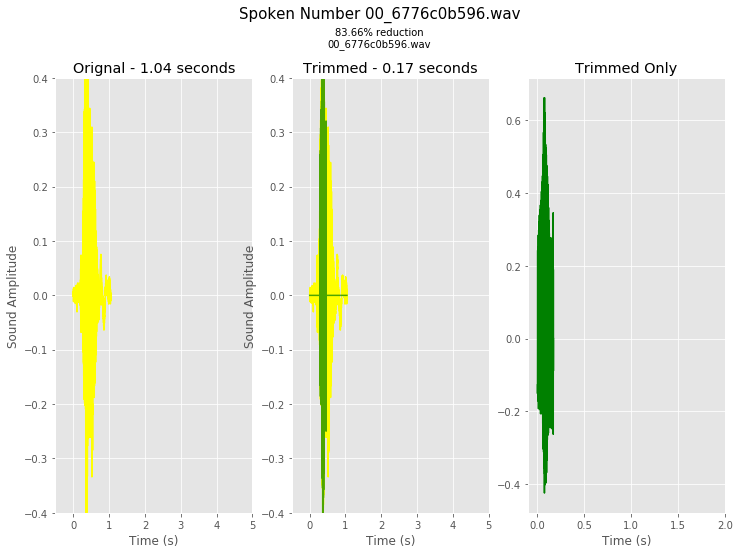

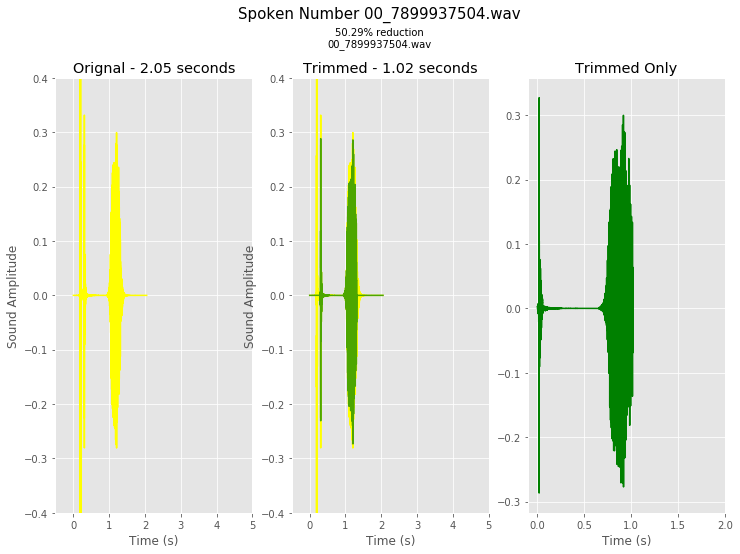

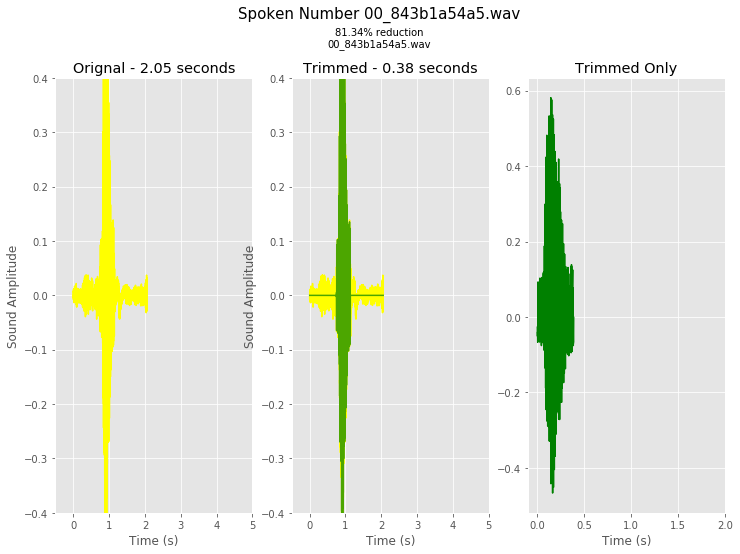

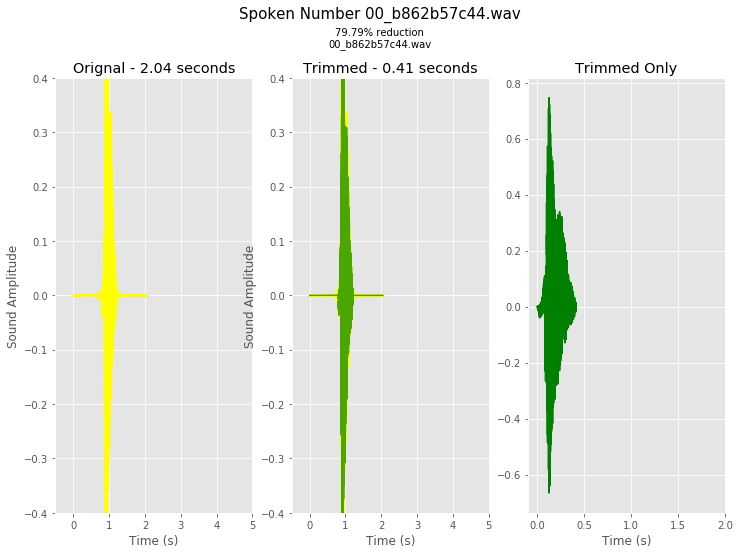

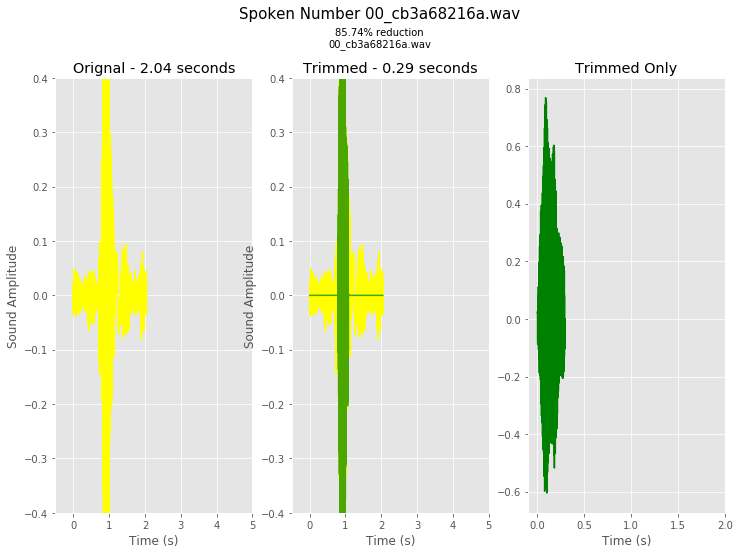

In [9]:
#graph original file and trimmed file next to each other
for i, file in enumerate(working_files):
   
    #process working directory  - original file
    audio, sfreq = lr.load(os.path.join(working_dir,file))
    time = np.arange(0, len(audio)) / sfreq
    e_time = max(time,default=1)

    #process trimmed file
    audio_trim, sfreq_trim = lr.load(os.path.join(trim_dir, trim_files[i]))
    time_trim = np.arange(0, len(audio_trim)) / sfreq_trim
    e_time_trim = max(time_trim,default=1)
    
    #process special file
    audio_spl, sfreq_spl = lr.load(os.path.join(spl_dir, spl_files[i]))
    time_spl = np.arange(0, len(audio_spl)) / sfreq_spl
    e_time_spl = max(time_spl,default=1)
      
    #setup plot
    fig,ax = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(12,8))
    plt.subplots_adjust(hspace=1)
    
    #plot original file
    plt.subplot(1,3,1)
    plt.plot(time, audio, 'yellow', alpha=1, label='Orignal')
    plt.xlabel('Time (s)')
    plt.ylabel('Sound Amplitude')
    plt.ylim([-.40, .4])
    plt.xlim([-.5, 5])
    plt.title(f'Orignal - {e_time:.2f} seconds')

    #plot trimmed file
    plt.subplot(1,3,2)

    plt.plot(time, audio, 'yellow', alpha=1, label='Orignal')
    plt.xlabel('Time (s)')
    plt.ylabel('Sound Amplitude')
    plt.ylim([-.40, .4])
    plt.xlim([-.5, 5])
    plt.title(f'Orignal - {e_time:.2f} seconds')
      
    plt.plot(time_spl, audio_spl, 'green', alpha=.7, label='Trimmed')
    plt.xlabel('Time (s)')
    plt.ylim([-.40, .4])
    plt.xlim([-.5, 5])
    plt.title(f'Trimmed - {e_time_trim:.2f} seconds')
    
    #plot trimmed file
    plt.subplot(1,3,3)
    plt.plot(time_trim, audio_trim, 'g', alpha=1, label='Trimmed')
    plt.xlabel('Time (s)')
    plt.xlim([-.1, 2])
    plt.title(f'Trimmed Only')
    
    plt.subplots_adjust(hspace=50)  #adjust space for titles
      
    #plot titles - centered over both charts
    title = f"Spoken Number {str(file.split('-')[0])}"
    plt.figtext(0.5,.99, title, ha='center', va='center', fontsize=15)

    d_time = (e_time - e_time_trim) / e_time
    title = f"{d_time:.2%} reduction"
    plt.figtext(0.5,.96, title, ha='center', va='center', fontsize=10)
    
    plt.figtext(0.5,.94, file, ha='center', va='center', fontsize=10)

    plt.show()
    

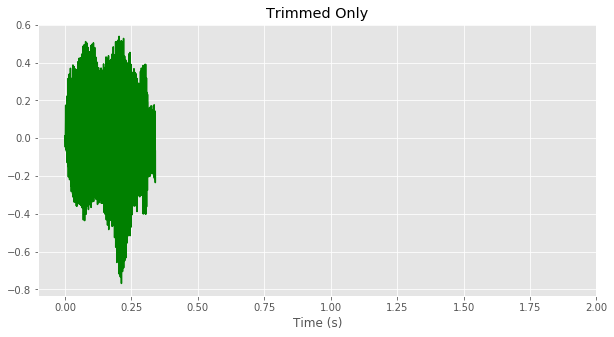

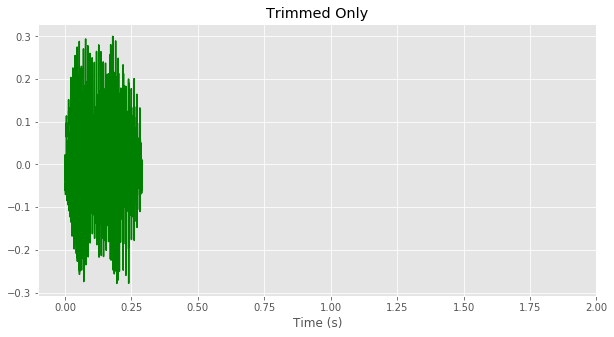

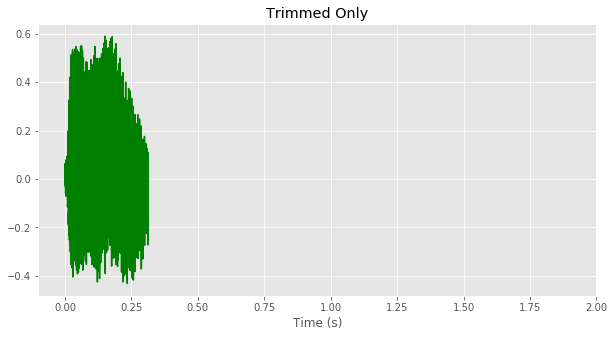

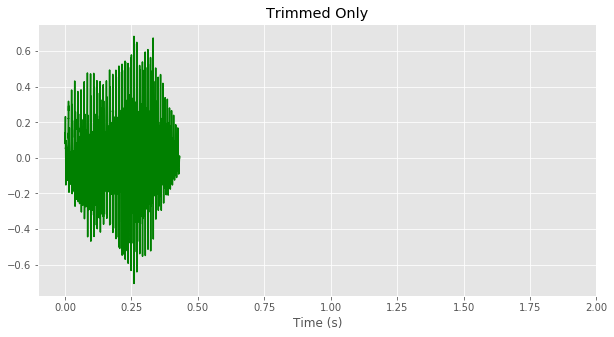

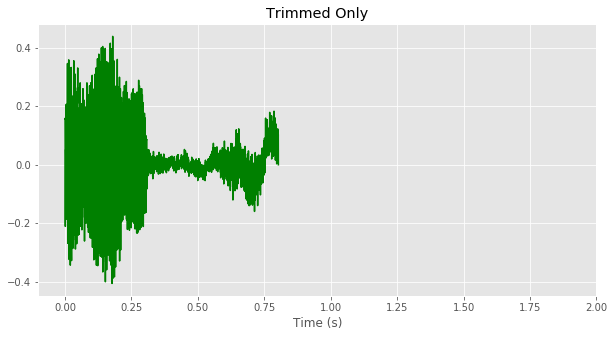

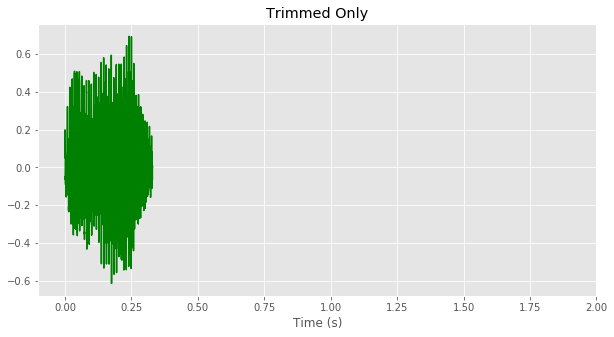

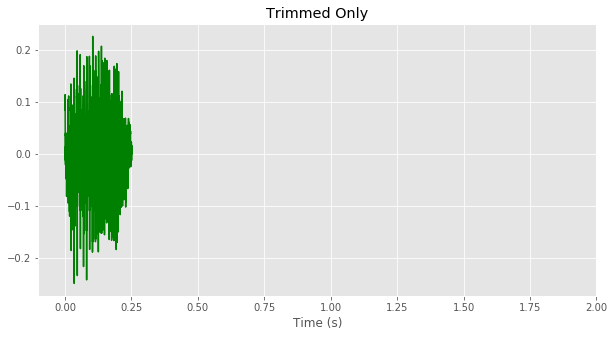

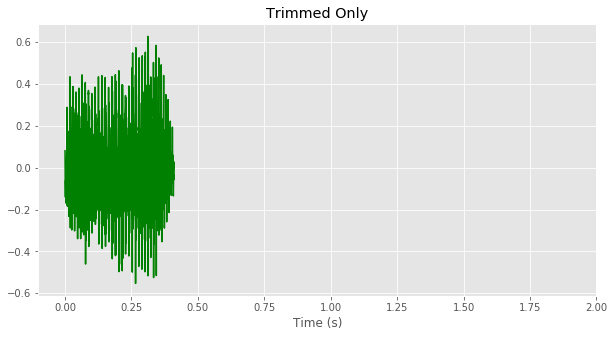

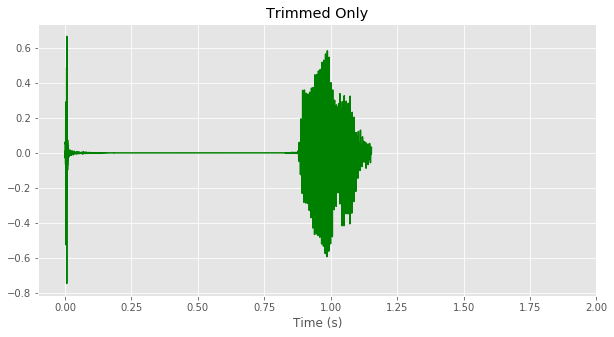

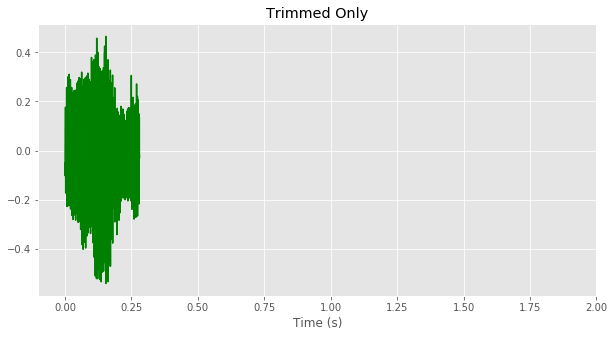

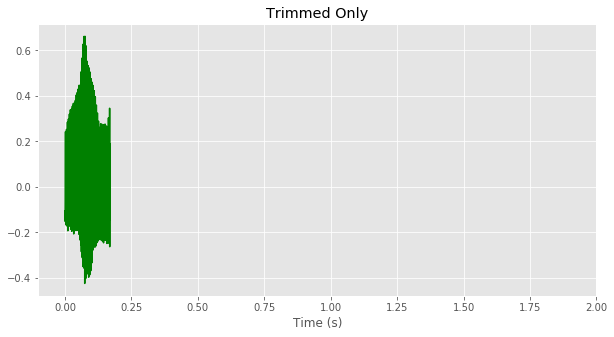

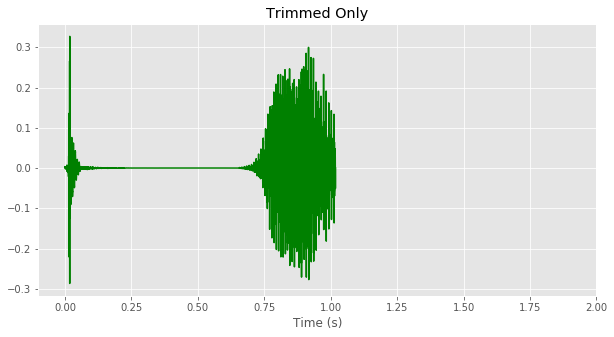

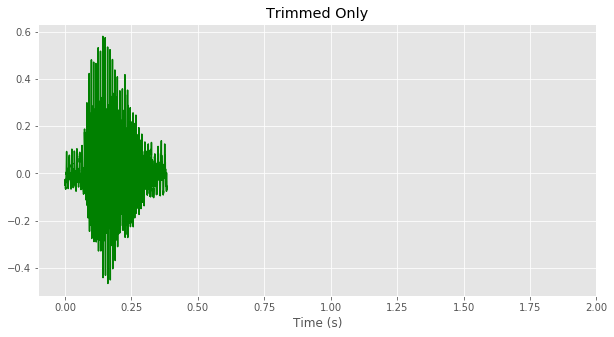

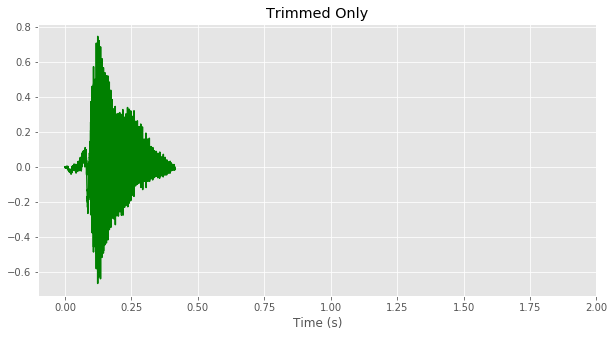

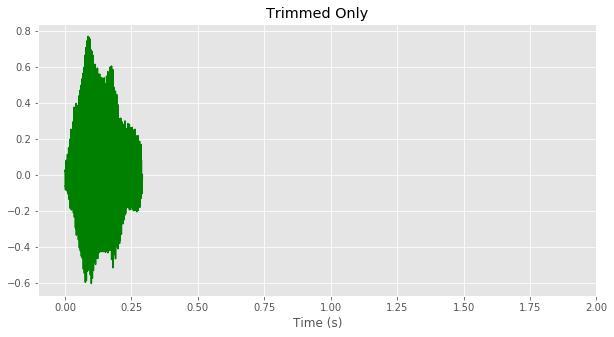

In [10]:
#graph and save original trimmed file (note y scales vary)
#ultimately plan on using in classifier
# need to determin best format for classifier

for i, file in enumerate(working_files):
    
    dBFS_filename = os.path.join(dBFS_dir,dBFS_files[i])
        
    #process trimmed file
    audio_trim, sfreq_trim = lr.load(os.path.join(trim_dir, trim_files[i]))
    time_trim = np.arange(0, len(audio_trim)) / sfreq_trim
    e_time_trim = max(time_trim,default=1)
         
    plt.figure(figsize=(10,5))
    
    #plot trimmed file
    plt.plot(time_trim, audio_trim, 'g', alpha=1, label='Trimmed')
    plt.xlabel('Time (s)')
    plt.xlim([-.1, 2])
    plt.title(f'Trimmed Only')
    plt.savefig(dBFS_filename)
         
    plt.show()
    


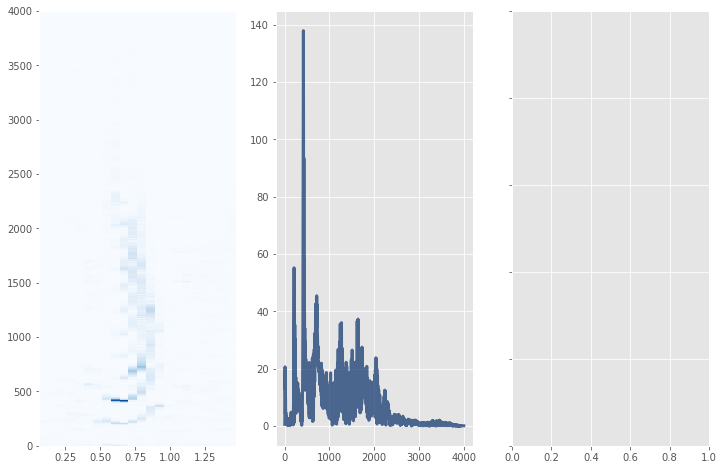

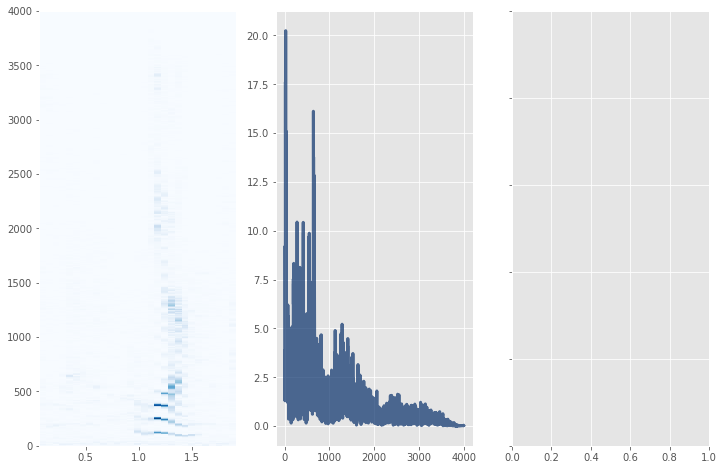

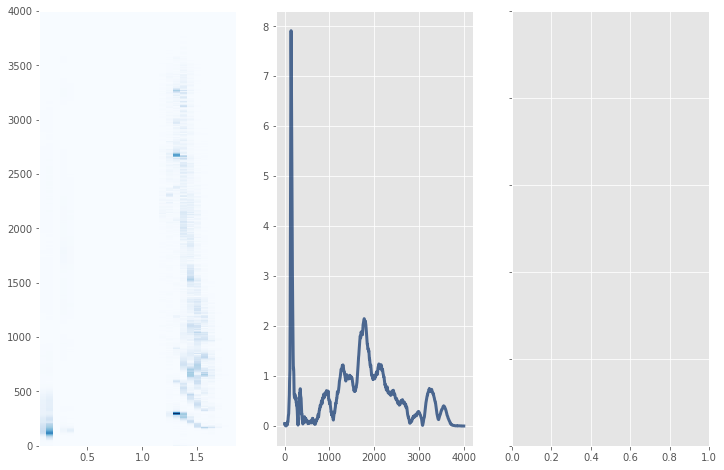

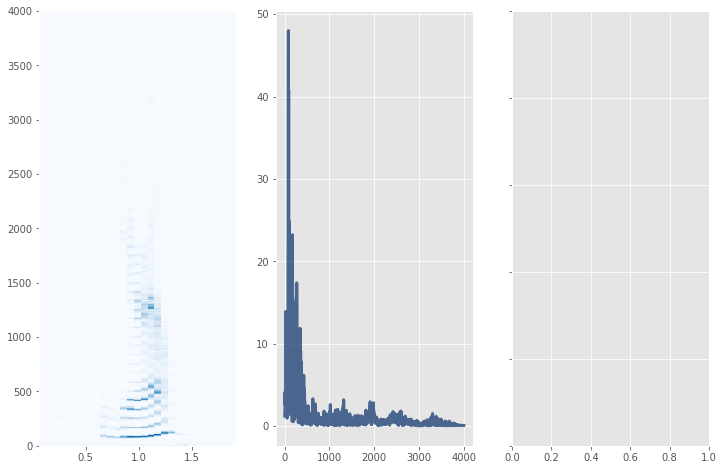

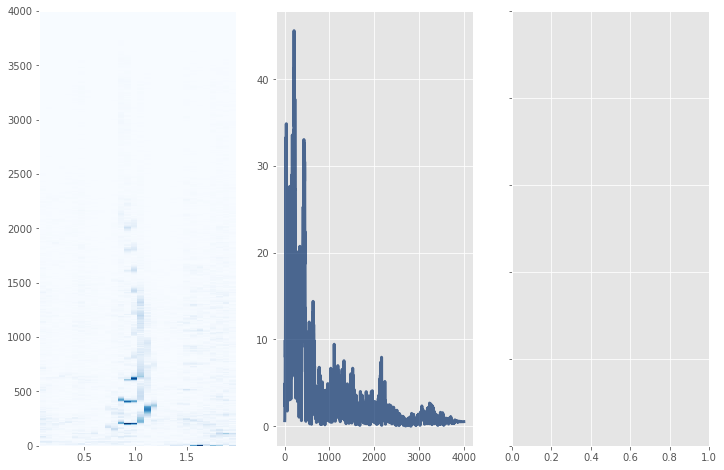

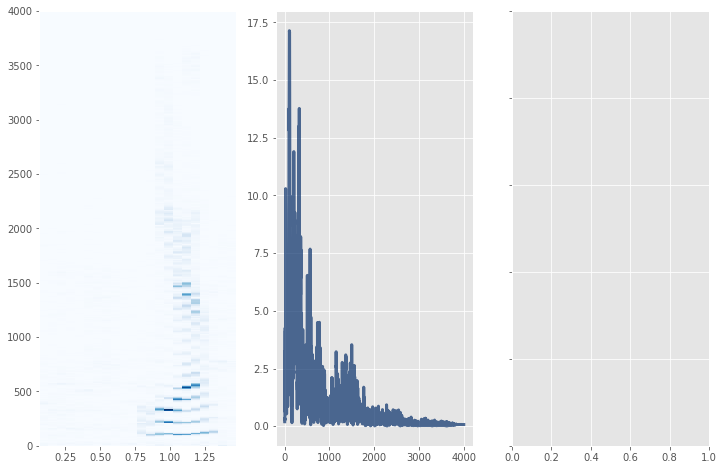

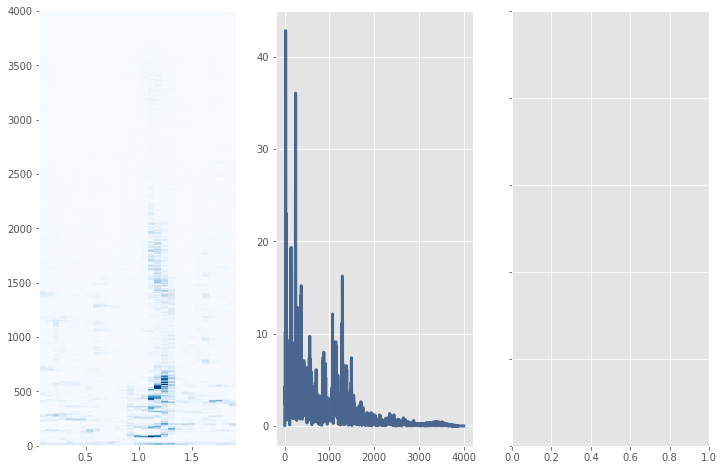

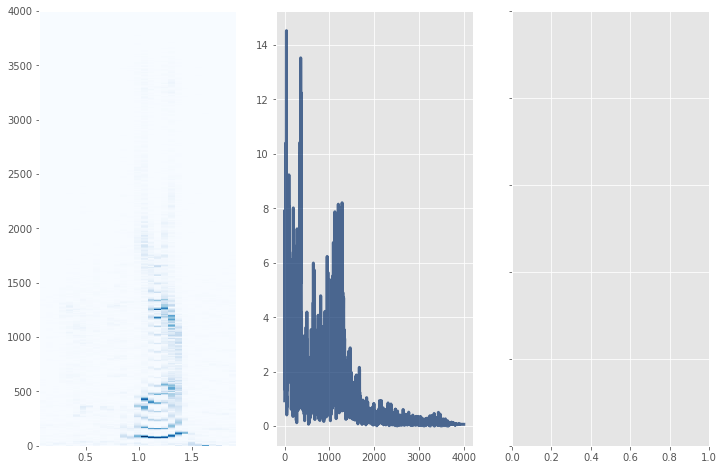

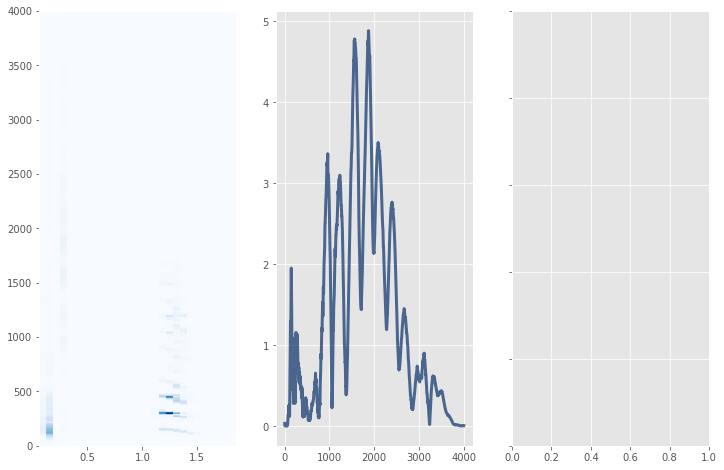

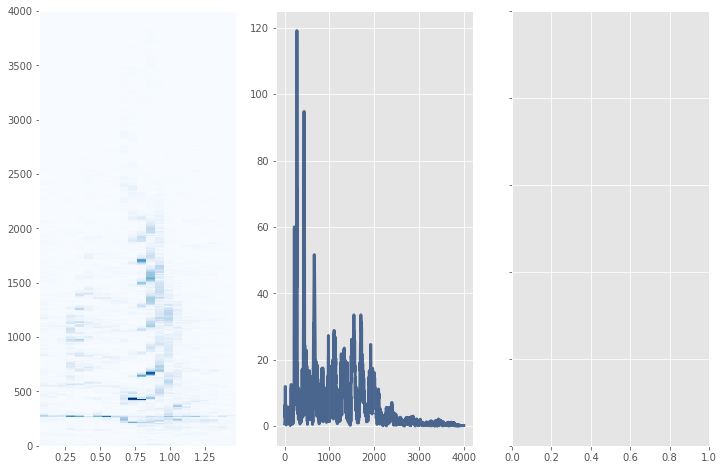

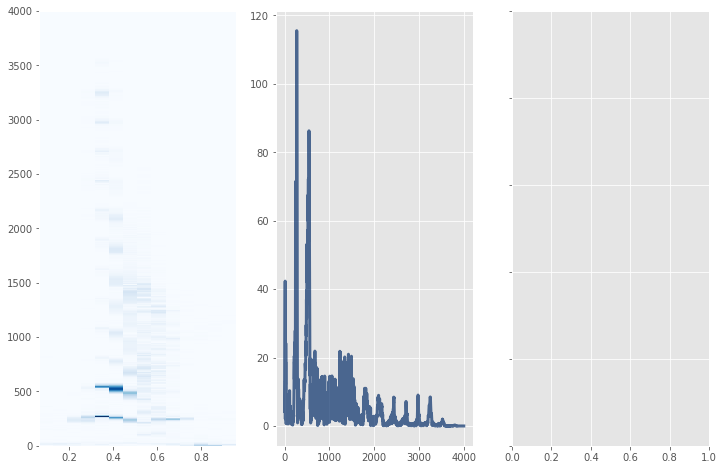

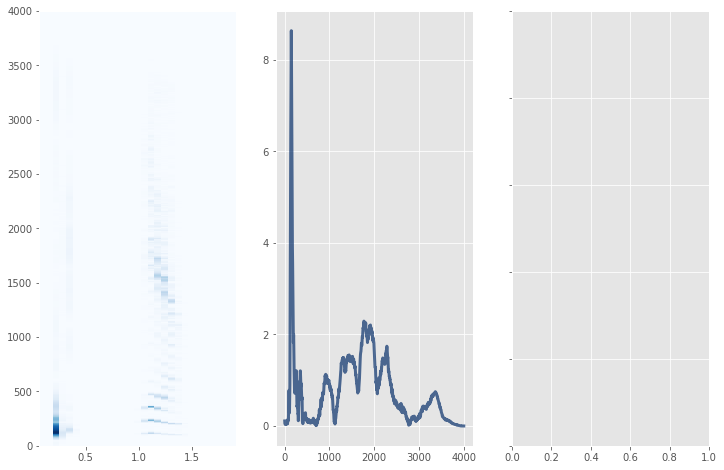

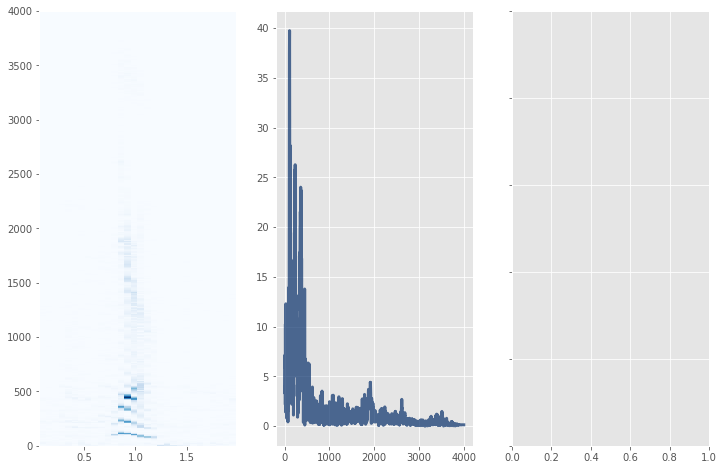

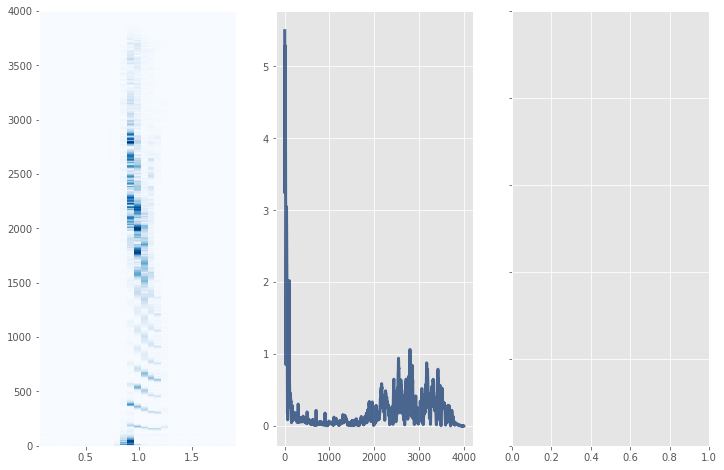

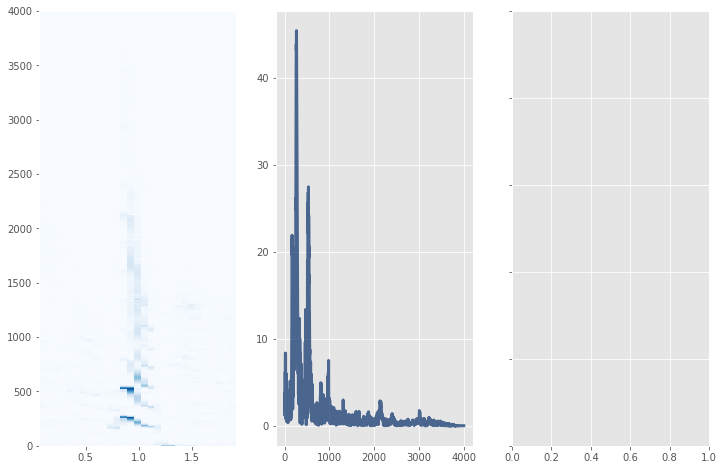

In [11]:
#a few additional graphs I just started working with...
for i, file in enumerate(working_files):
    fig,ax = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(12,8))
    plt.subplots_adjust(hspace=1)
    
    #plot original file
    plt.subplot(1,3,1)
    #process_spectrogram
    spect = thinkdsp.read_wave(os.path.join(working_dir, file))
    spectrogram = spect.make_spectrogram(seg_length=1024)
    spectrogram.plot(high=5000)
    
    plt.subplot(1,3,2)
    start = .25
    duration = 0.6
    segment = spect.segment(start, duration)
    spectrum = segment.make_spectrum()
    spectrum.plot()
    
    

In [22]:
### Below is some copied code I plan on using...

# #graph original file and trimmed file next to each other
# train_images = []
# for i, file in enumerate(working_files):
#     dBFS_filename = os.path.join(dBFS_dir,dBFS_files[i])
#     train_images.append(dBFS_filename)

# len(train_images)
    
    

In [23]:
# #all_cols contains all the fields we are going to use for training
# all_cols = list(log)
# all_cols.remove('File_Name')
# # print(all_cols)
# # sys.exit(0)

# #y contains label
# y = log['Spoken_Nbr']
# all_cols.remove('Spoken_Nbr')



# classifiers = [
# #     KNeighborsClassifier(2, n_jobs = -1),
# #     SVC(kernel="rbf", C=0.025, probability=True),
# #     NuSVC(probability=True),
# #     DecisionTreeClassifier(),
#     RandomForestClassifier(n_estimators=100, n_jobs = -1)
# #     AdaBoostClassifier(),
# #     GradientBoostingClassifier(),
# #     GaussianNB(),
# #     LinearDiscriminantAnalysis()
# #     QuadraticDiscriminantAnalysis()
# ]

# # Logging for Visual Comparison
# # log_cols=["Classifier", "Accuracy", "Log Loss", "MCC", 'Col_Name', 'TN', 'FP', 'FN', 'TP', 'Total', 'Elapsed_Time' ]
# # log = pd.DataFrame(columns=log_cols)

# # warnings.filterwarnings('ignore')

# features = ['dBFS_mean', 'dBFS_std', 'dBFS_thresh', 'org_dur', 'trim_dur']
# features_v = log[features]

# pred_v = log['Spoken_Nbr']

# # # carrier is not a number, so transform it into an number
# # features_v['carrier'] = pd.factorize(features_v['carrier'])[0]

# scaled_features_v = train_images

# X_train, X_test, y_train, y_test = train_test_split(
# scaled_features_v, pred_v, test_size=0.30, random_state=5)
# clf = RandomForestClassifier(n_estimators=1000, n_jobs = -1)
# clf.fit(X_train, y_train)
# name = clf.__class__.__name__
# train_predictions = clf.predict(X_test)
# acc = accuracy_score(y_test, train_predictions)
# train_predictions = clf.predict_proba(X_test)
# ll = log_loss(y_test, train_predictions)


# #     print(X_train)
# print(mcc)


### Scratch items below

In [14]:
# spectrogram = audio.make_spectrogram(seg_length=1024)
# spectrogram.plot(high=5000)

In [15]:
# start = .25
# duration = 0.6
# segment = audio.segment(start, duration)

In [16]:
# audio = thinkdsp.read_wave('working/04_837a1b7321.wav')
# audio.make_audio()

In [17]:
# spectrum = segment.make_spectrum()
# spectrum.plot()

In [18]:
# spectrum.peaks()[:5]

In [19]:
# audio = thinkdsp.read_wave(t_filename)
# audio.make_audio()

In [20]:
# audio = thinkdsp.read_wave(s_filename)
# audio.make_audio()

In [21]:
# audio = thinkdsp.read_wave(m_filename)
# audio.make_audio()